In [95]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn import preprocessing

In [3]:
%%time
stations = pd.read_csv('data_raw/babs_open_data_year_3/201608_station_data.csv', skipinitialspace= True)
status = pd.read_csv('data_raw/babs_open_data_year_3/201608_status_data.csv', 
                     parse_dates = [3], infer_datetime_format = True, skipinitialspace= True)
trips = pd.read_csv('data_raw/babs_open_data_year_3/201608_trip_data.csv', 
                   parse_dates = ['Start Date', 'End Date'], infer_datetime_format = True, skipinitialspace= True)
weathers = pd.read_csv('data_raw/babs_open_data_year_3/201608_weather_data.csv',
                      parse_dates = ['PDT'], infer_datetime_format = True, skipinitialspace= True)

CPU times: user 3min 48s, sys: 20.4 s, total: 4min 9s
Wall time: 4min 23s


In [76]:
stations = stations.dropna(how = 'all')
status = status.dropna(how = 'all')
trips = trips.dropna(how = 'all')
weathers = weathers.dropna(how = 'all')
cal = calendar()
holidays = cal.holidays(start = trips['Start Date'].min(), end = trips['Start Date'].max())

# Introduction

The purpose of this document is to predict the demand of each station in a giving time.
The procedures are as followed:
1. Define 'demand' as number of bike borrowed from one station in a given time period. We'll further classified the demand to 5 levels, from 1 to 5, each will represent 20% quantile of the demand distribution.

2. From the previous data exploration, we've identified that the station(location), date, time and temperature are the important factors impacting the demand. We'll use those factors to train the data.

3. We'll train the model using the dataset in 2016. However, we'll expend the training set to the datasets from 2013 to 2016.

# Define demand
We'll define demand as number of bike will be borrowed in the future 15 minutes. Therefore, we will have 4 period in each hour. 

In [85]:
# 
t = trips.set_index('Start Date')
t = t.groupby([pd.TimeGrouper('15min'), 'Start Terminal']).size().unstack('Start Terminal').fillna(0)

t = t.stack().reset_index('Start Terminal')
t = t.rename(columns = {0: 'Demand'})
t['year'] = t.index.year
t['month'] = t.index.month
t['day'] = t.index.day
t['hour'] = t.index.hour
t['min'] = t.index.minute
t['PDT'] = t.index.date
t['PDT'] = pd.to_datetime(t.PDT)
t = t.reset_index()
weekday = t['Start Date'].dt.weekday
t['workday'] = weekday.isin([0,1,2,3,4]) & (t['Start Date'].isin(holidays) == False)

In [86]:
# Clean data in weathers  
w = weathers
w.PrecipitationIn = w.PrecipitationIn.replace('T', '0.005')
w.PrecipitationIn = pd.to_numeric(w.PrecipitationIn)
w = w.drop(['Max Gust SpeedMPH', 'Events'], axis = 'columns')
w = w.fillna(w.mean())
ziplocation = {94107:'San Francisco', 94301:'Palo Alto', 94041:'Mountain View', 95113:'San Jose'}
w['landmark'] = w.ZIP.map(ziplocation)

# Join data with stations and weathers
s = stations.set_index('station_id').loc[:, ['lat', 'long', 'dockcount', 'landmark']]
m = pd.merge(t, s, how ='inner', left_on='Start Terminal', right_index= True)

m = pd.merge(m, w, how ='inner', left_on = ['PDT', 'landmark'], right_on = ['PDT', 'landmark'])
m = m.dropna(axis =1, how='all')

In [94]:
X = m.drop('Demand', axis = 1)
Y = m.Demand
X = X.drop(['Start Date','landmark','PDT', 'ZIP','dockcount'], axis = 1)
X_cat = X.loc[:,['Start Terminal','workday']]
X_num = X.drop(['Start Terminal','workday'], axis =1)


In [100]:
X_cat

,Start Terminal,workday
0,2,True
1,2,True
2,2,True
3,2,True
4,2,True
5,2,True
6,2,True
7,2,True
8,2,True
9,2,True


In [118]:
list(X_num)

['year',
 'month',
 'day',
 'hour',
 'min',
 'lat',
 'long',
 'Max TemperatureF',
 'Mean TemperatureF',
 'Min TemperatureF',
 'Max Dew PointF',
 'MeanDew PointF',
 'Min DewpointF',
 'Max Humidity',
 'Mean Humidity',
 'Min Humidity',
 'Max Sea Level PressureIn',
 'Mean Sea Level PressureIn',
 'Min Sea Level PressureIn',
 'Max VisibilityMiles',
 'Mean VisibilityMiles',
 'Min VisibilityMiles',
 'Max Wind SpeedMPH',
 'Mean Wind SpeedMPH',
 'PrecipitationIn',
 'CloudCover',
 'WindDirDegrees',
 'Start Terminal',
 'Workday']

In [132]:
# Preprocessing the data
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le1.fit(X_cat.iloc[:,0])
le2.fit(X_cat.iloc[:,1])

#X = X_num + list(le1.transform(X_cat.iloc[:,0])) + list(le2.transform(X_cat.iloc[:,0]))
X = X_num
X['Start Terminal'] = le1.transform(X_cat.iloc[:,0])
X['Workday'] = le2.transform(X_cat.iloc[:,1])
X = X.loc[:,['hour', 'Workday']]

In [133]:
lm = LinearRegression()
lm.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

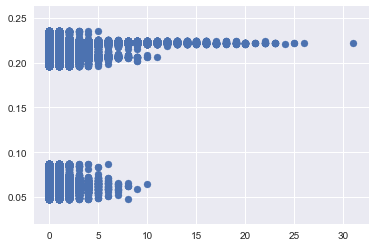

In [134]:
plt.scatter(x=Y, y=lm.predict(X))

In [125]:
factors = list(X)
factors

['Start Terminal', 'hour', 'Workday', 'Mean TemperatureF']

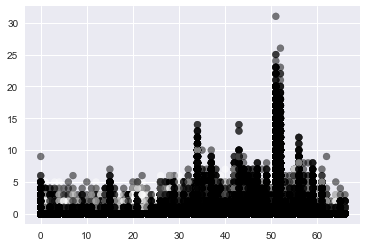

In [129]:
plt.scatter(y = Y, x= X[factors[0]], c = X[factors[2]], alpha = 0.5)


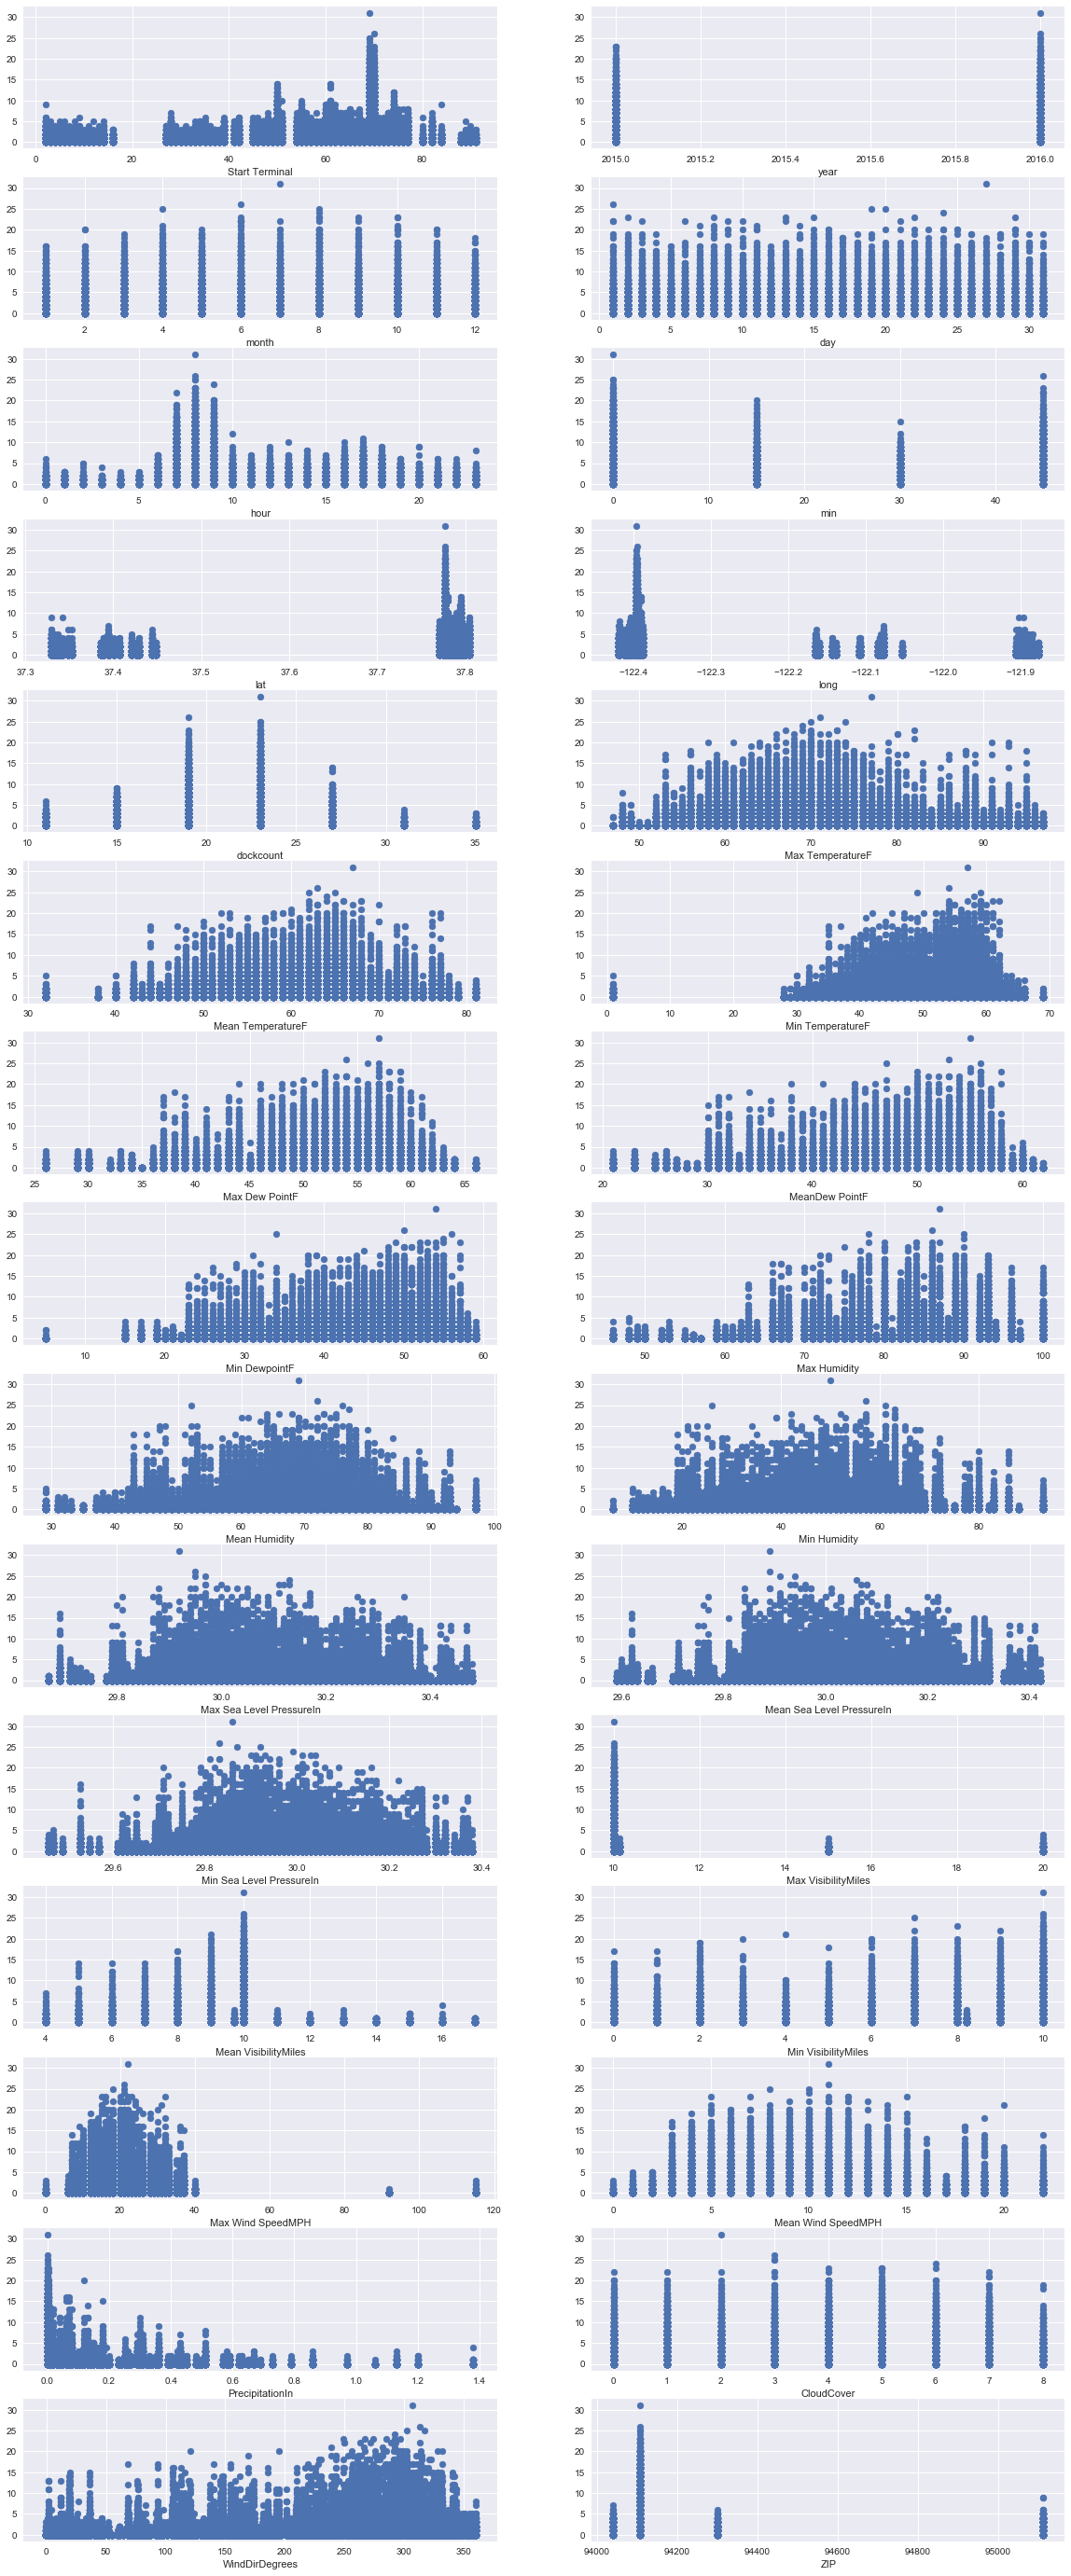

In [61]:
# Plot data
len(factors)
fig, axes = plt.subplots(int(len(factors)/2),2,figsize = (20,50))

for i,ax in enumerate(axes):
    for j,x in enumerate(ax):
        x.scatter(y=Y, x=X[factors[i*2+j]])
        x.set_xlabel(factors[i*2+j])
